In [3]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

def load_df(csv_path='/Users/liaopeng3/logs/google_analytics_all/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

print(os.listdir("/Users/liaopeng3/logs/google_analytics_all/"))

['test_format.csv', 'train_df_3.csv', 'train_format.csv', 'train_format_lgbm_short.csv', 'test.csv', 'test_format_lgbm.csv', 'test_format_lgbm_short.csv', 'train_format_lgbm.csv', 'train.csv', 'sample_submission.csv']


In [5]:
%%time
train_df = load_df()
test_df = load_df("/Users/liaopeng3/logs/google_analytics_all/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 3min 57s, sys: 17.5 s, total: 4min 15s
Wall time: 4min 19s


In [6]:
(train_df.shape,test_df.shape)

((903653, 55), (804684, 53))

In [34]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'device.browser', 'device.browserSize', 'device.browserVersion',
       'device.deviceCategory', 'device.flashVersion', 'device.isMobile',
       'device.language', 'device.mobileDeviceBranding',
       'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName',
       'device.mobileDeviceModel', 'device.mobileInputSelector',
       'device.operatingSystem', 'device.operatingSystemVersion',
       'device.screenColors', 'device.screenResolution', 'geoNetwork.city',
       'geoNetwork.cityId', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.metro',
       'geoNetwork.networkDomain', 'geoNetwork.networkLocation',
       'geoNetwork.region', 'geoNetwork.subContinent', 'totals.bounces',
       'totals.hits', 'totals.newVisits', 'totals.pageviews',
       'totals.transactionRevenue

In [8]:
# # %%time
# train_df.to_csv('/Users/liaopeng3/logs/google_analytics_all/train_format_lgbm.csv',index=False)
# test_df.to_csv('/Users/liaopeng3/logs/google_analytics_all/test_format_lgbm.csv',index=False)

In [9]:
# %%time
train_df.head(1000).to_csv('/Users/liaopeng3/logs/google_analytics_all/train_format_lgbm_short.csv',index=False)
test_df.head(1000).to_csv('/Users/liaopeng3/logs/google_analytics_all/test_format_lgbm_short.csv',index=False)

# Existed Data

In [40]:
# %%time
train_df =  pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/train_format_lgbm.csv')


/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
test_df =  pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/test_format_lgbm.csv')

In [11]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


In [12]:
(train_df.shape,test_df.shape)

((903653, 55), (804684, 53))

In [42]:
target = train_df['totals.transactionRevenue'].fillna(0).astype(float)


In [44]:
target = target.apply(lambda x: np.log1p(x))


In [ ]:
del train_df['totals.transactionRevenue']

In [41]:
train_df['totals.transactionRevenue'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: totals.transactionRevenue, dtype: float64

In [45]:
target.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: totals.transactionRevenue, dtype: float64

In [14]:
columns = [col for col in train_df.columns if train_df[col].nunique() > 1]
#____________________________
train_df = train_df[columns]
test_df = test_df[columns]

In [15]:
trn_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df])

In [16]:
trn_len

903653

In [17]:
merged_df.shape[0] - trn_len

804684

In [18]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,...,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,...,NaN,NaN,NaN,NaN,NaN,(not set),google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,...,NaN,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google


In [19]:
merged_df['diff_visitId_time'] = merged_df['visitId'] - merged_df['visitStartTime']
merged_df['diff_visitId_time'] = (merged_df['diff_visitId_time'] != 0).astype(int)
del merged_df['visitId']

In [20]:
del merged_df['sessionId']

In [21]:
merged_df.head()

,channelGrouping,date,fullVisitorId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,...,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,diff_visitId_time
0,Organic Search,20160902,1131660440785968503,1,1472830385,Chrome,desktop,False,Windows,Izmir,...,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,0
1,Organic Search,20160902,377306020877927890,1,1472880147,Firefox,desktop,False,Macintosh,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,0
2,Organic Search,20160902,3895546263509774583,1,1472865386,Chrome,desktop,False,Windows,Madrid,...,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,0
3,Organic Search,20160902,4763447161404445595,1,1472881213,UC Browser,desktop,False,Linux,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),google + online,organic,NaN,google,0
4,Organic Search,20160902,27294437909732085,2,1472822600,Chrome,mobile,True,Android,not available in demo dataset,...,NaN,NaN,NaN,NaN,(not set),(not provided),organic,NaN,google,0


In [24]:
format_str = '%Y%m%d' 
merged_df['formated_date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x), format_str))
merged_df['WoY'] = merged_df['formated_date'].apply(lambda x: x.isocalendar()[1])
merged_df['month'] = merged_df['formated_date'].apply(lambda x:x.month)
merged_df['quarter_month'] = merged_df['formated_date'].apply(lambda x:x.day//8)
merged_df['weekday'] = merged_df['formated_date'].apply(lambda x:x.weekday())

del merged_df['date']
del merged_df['formated_date']

In [25]:
merged_df['formated_visitStartTime'] = merged_df['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
merged_df['formated_visitStartTime'] = pd.to_datetime(merged_df['formated_visitStartTime'])
merged_df['visit_hour'] = merged_df['formated_visitStartTime'].apply(lambda x: x.hour)

del merged_df['visitStartTime']
del merged_df['formated_visitStartTime']

In [26]:
for col in merged_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour', 'WoY']: continue
    if merged_df[col].dtypes == object or merged_df[col].dtypes == bool:
        merged_df[col], indexer = pd.factorize(merged_df[col])

train_df = merged_df[:trn_len]
test_df = merged_df[trn_len:]

In [27]:
train_df.shape

(903653, 32)

In [28]:
test_df.shape

(804684, 32)

In [51]:
param = {'num_leaves': 300,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 1,
         "verbosity": -1}

In [52]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
start = time.time()
features = list(train_df.columns)
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    trn_data = lgb.Dataset(train_df.iloc[trn_idx].values, label=target.iloc[trn_idx].values)
    val_data = lgb.Dataset(train_df.iloc[val_idx].values, label=target.iloc[val_idx].values)
    
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx].values, num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df.values, num_iteration=clf.best_iteration) / folds.n_splits

Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.57099	valid_1's rmse: 1.63498
Early stopping, best iteration is:
[47]	training's rmse: 1.56932	valid_1's rmse: 1.63506
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56895	valid_1's rmse: 1.63841
Early stopping, best iteration is:
[28]	training's rmse: 1.56548	valid_1's rmse: 1.63651
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56542	valid_1's rmse: 1.64693
Early stopping, best iteration is:
[35]	training's rmse: 1.5624	valid_1's rmse: 1.64567
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56139	valid_1's rmse: 1.67208
Early stopping, best iteration is:
[35]	training's rmse: 1.55914	valid_1's rmse: 1.67067
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.56718	valid_1's rmse: 1.64119
Early stopping, best iteration is:
[26]	training's rmse

In [53]:
print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

CV score: 1.64537 


/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


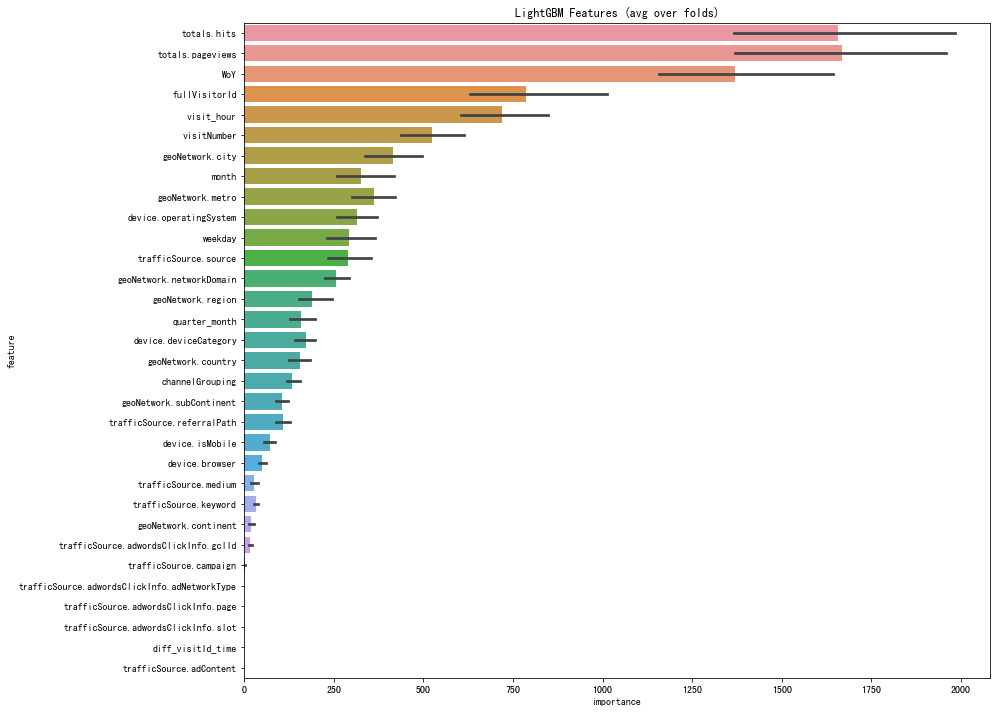

In [54]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:1000].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

There are some negative values in the predictions. So let us make them 0. Also let us sum up the prediction of multiple instances of a vistor to get one value per visitor. Finally let us take log value of these predictions. 

In [55]:
# submission = test_df[['fullVisitorId']].copy()
# #submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)

# submission.loc[:, 'PredictedLogRevenue'] = predictions
# grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
# #grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
# grouped_test.to_csv('submit.csv',index=False)

In [56]:
submission = test_df[['fullVisitorId']].copy()
#submission.loc[:, 'PredictedLogRevenue'] = np.expm1(predictions)

submission.loc[:, 'PredictedLogRevenue'] = predictions
grouped_test = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum().reset_index()
#grouped_test["PredictedLogRevenue"] = np.log1p(grouped_test["PredictedLogRevenue"])
grouped_test.to_csv('submit.csv',index=False)

In [57]:
grouped_test.head()

,fullVisitorId,PredictedLogRevenue
0,259678714014,0.410699
1,3038793126460,0.006225
2,9663019041506,0.003112
3,10438463470860,0.003112
4,10992980461157,0.008530


In [58]:
grouped_test.index.size

650489

In [21]:
qq=pd.read_csv('baseline_lgb.csv')

In [22]:
qq.index.size

617242

In [24]:
grouped_test.drop_duplicates('fullVisitorId').index.size

650489

In [25]:
submission.index.size

804684

In [26]:
test_df.index.size

804684

In [27]:
grouped_test.groupby('fullVisitorId').count().sort_values('PredictedLogRevenue',ascending=False).head()

,PredictedLogRevenue
fullVisitorId,
259678714014,1
9441045230930259433,1
9440798854490479605,1
9440822432247222030,1
9440913224224335508,1


In [28]:
grouped_test.loc[grouped_test['fullVisitorId']==1002145056479546512]

,fullVisitorId,PredictedLogRevenue
90349,1002145056479546512,0.003112


In [29]:
ww =  pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/test.csv')

/Users/liaopeng3/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



In [37]:
# ww.index.size
ww.drop_duplicates('fullVisitorId').shape

(652237, 12)

In [35]:
ee = pd.read_csv('/Users/liaopeng3/logs/google_analytics_all/sample_submission.csv')

In [36]:
ee.shape

(617242, 2)